In [14]:
def create_extent(lat, lon, lat_distance=0.001, lon_distance=0.001):
    """
    Create an extent string compatible with NOAA API that matches Google Maps API V3 LatLngBounds.toUrlValue format.

    Parameters:
    - lat (float): Latitude of the center point.
    - lon (float): Longitude of the center point.
    - lat_distance (float): Half the distance to extend latitude by (default: 0.1 degree).
    - lon_distance (float): Half the distance to extend longitude by (default: 0.1 degree).

    Returns:
    - extent (str): Extent string in the format "southwest_latitude,southwest_longitude|northeast_latitude,northeast_longitude".
    """
    # Calculate southwest and northeast corners
    southwest_lat = lat - lat_distance
    southwest_lon = lon - lon_distance
    northeast_lat = lat + lat_distance
    northeast_lon = lon + lon_distance

    # Format to match Google Maps API V3 LatLngBounds.toUrlValue format
    extent = f"{southwest_lat},{southwest_lon}|{northeast_lat},{northeast_lon}"
    return extent

In [69]:
create_extent(37.7749, -122.4194)  # (-123.4194, 36.7749, -121.4194, 38.7749)

'37.773900000000005,-122.4204|37.7759,-122.41839999999999'

In [15]:
import requests
from geopy.distance import geodesic

# Replace with your coordinates
user_location = (39.5, -96.5)  # Example coordinates (latitude, longitude)
ext = create_extent(user_location[0], user_location[1])
print(ext)
lat = user_location[0]
lon = user_location[1]

# Get NOAA stations metadata
stations_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations"
headers = {"token": "XeVRiGIYmbnDCzzMCnjWCioSDjUYZXPi"}

# Optionally, filter to stations in the contiguous US
params = {
    "extemt": ext,
    "limit": 1000,  # Adjust as needed
}

response = requests.get(stations_url, headers=headers, params=params)
stations = response.json()["results"]

# Calculate the distance to each station
distances = []
for station in stations:
    station_location = (station["latitude"], station["longitude"])
    distance = geodesic(user_location, station_location).miles
    distances.append((station["id"], distance))

# Find the nearest station
nearest_station = min(distances, key=lambda x: x[1])[0]
station_distance = min(distances, key=lambda x: x[1])[1]
print(f"Nearest Station ID: {nearest_station} (Distance: {station_distance:.2f} miles)")

39.499,-96.501|39.501,-96.499
Nearest Station ID: COOP:030586 (Distance: 252.23 miles)


In [ ]:
stations

[{'elevation': 139,
  'mindate': '1948-01-01',
  'maxdate': '2014-01-01',
  'latitude': 31.5702,
  'name': 'ABBEVILLE, AL US',
  'datacoverage': 0.8813,
  'id': 'COOP:010008',
  'elevationUnit': 'METERS',
  'longitude': -85.2482},
 {'elevation': 239.6,
  'mindate': '1938-01-01',
  'maxdate': '2015-11-01',
  'latitude': 34.21096,
  'name': 'ADDISON, AL US',
  'datacoverage': 0.5059,
  'id': 'COOP:010063',
  'elevationUnit': 'METERS',
  'longitude': -87.17838},
 {'elevation': 302.1,
  'mindate': '1940-05-01',
  'maxdate': '1962-03-01',
  'latitude': 34.41667,
  'name': 'ADDISON CENTRAL TOWER, AL US',
  'datacoverage': 0.9658,
  'id': 'COOP:010071',
  'elevationUnit': 'METERS',
  'longitude': -87.31667},
 {'elevation': 172.5,
  'mindate': '1995-04-01',
  'maxdate': '2015-11-01',
  'latitude': 33.17835,
  'name': 'ALABASTER SHELBY CO AIRPORT ASOS, AL US',
  'datacoverage': 0.8064,
  'id': 'COOP:010116',
  'elevationUnit': 'METERS',
  'longitude': -86.78178},
 {'elevation': 183.8,
  'mindat

33.05,-119.25|35.05,-117.25
Nearest Station ID: COOP:045111 (Distance: 0.00 miles)


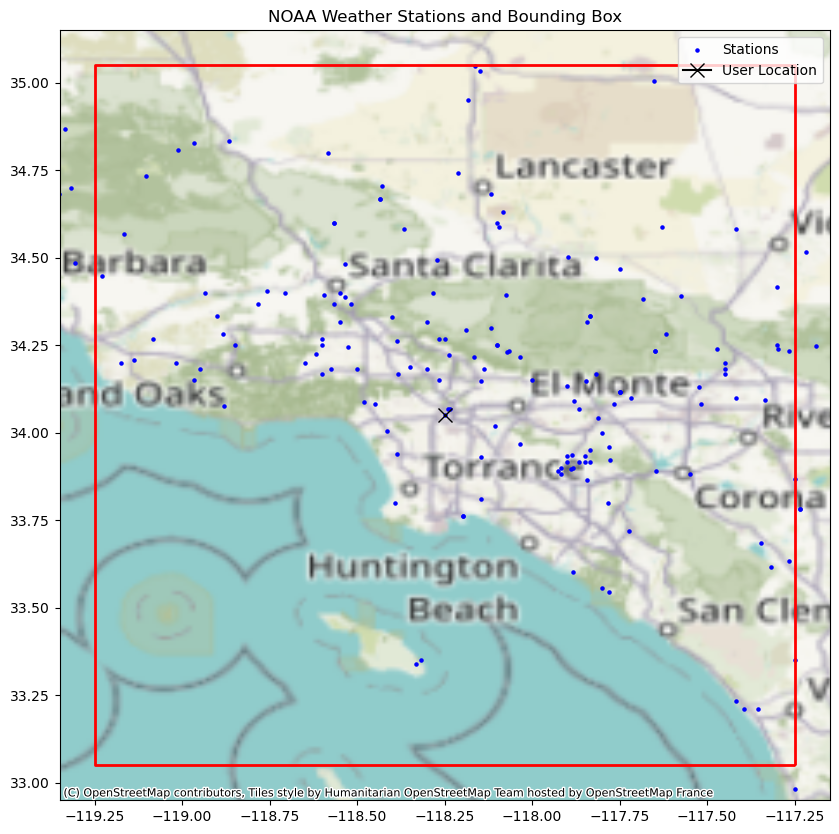

In [23]:
import requests
from geopy.distance import geodesic
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import contextily as ctx


def create_extent(lat, lon, lat_distance=1, lon_distance=1):
    southwest_lat = lat - lat_distance
    southwest_lon = lon - lon_distance
    northeast_lat = lat + lat_distance
    northeast_lon = lon + lon_distance
    extent = f"{southwest_lat},{southwest_lon}|{northeast_lat},{northeast_lon}"
    return extent, southwest_lat, southwest_lon, northeast_lat, northeast_lon


# User location

# User location
user_location = (34.05, -118.25)  # Example coordinates (latitude, longitude)
ext, sw_lat, sw_lon, ne_lat, ne_lon = create_extent(user_location[0], user_location[1])
print(ext)
# Get NOAA stations metadata
stations_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations"
headers = {"token": "XeVRiGIYmbnDCzzMCnjWCioSDjUYZXPi"}

# Optionally, filter to stations in the contiguous US
params = {
    "locationid": "FIPS:06",
    "limit": 1000,  # Adjust as needed
}

response = requests.get(stations_url, headers=headers, params=params)
stations = response.json()["results"]

# Calculate the distance to each station
distances = []
station_points = []
for station in stations:
    station_location = (station["latitude"], station["longitude"])
    distance = geodesic(user_location, station_location).miles
    distances.append((station["id"], distance))
    station_points.append(Point(station_location[1], station_location[0]))

# Find the nearest station
nearest_station = min(distances, key=lambda x: x[1])[0]
station_distance = min(distances, key=lambda x: x[1])[1]
print(f"Nearest Station ID: {nearest_station} (Distance: {station_distance:.2f} miles)")

# Create GeoDataFrames for plotting
bounding_box = box(sw_lon, sw_lat, ne_lon, ne_lat)
gdf_box = gpd.GeoDataFrame([1], geometry=[bounding_box], crs="EPSG:4326")
gdf_stations = gpd.GeoDataFrame(stations, geometry=station_points, crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot bounding box
gdf_box.boundary.plot(ax=ax, color="red", linewidth=2)

# Plot stations
gdf_stations.plot(ax=ax, color="blue", marker="o", markersize=5, label="Stations")

# Plot user location
ax.plot(
    user_location[1],
    user_location[0],
    marker="x",
    color="black",
    markersize=10,
    label="User Location",
)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, crs=gdf_box.crs.to_string())

# Set plot limits and labels
ax.set_xlim([sw_lon - 0.1, ne_lon + 0.1])
ax.set_ylim([sw_lat - 0.1, ne_lat + 0.1])
ax.set_title("NOAA Weather Stations and Bounding Box")
ax.legend()

plt.show()

In [31]:
import requests
from datetime import datetime

# NOAA API token and station ID
headers = {"token": "XeVRiGIYmbnDCzzMCnjWCioSDjUYZXPi"}
station_id = "COOP:045111"

# Dates for the query
start_date = "2020-08-20"
end_date = "2020-08-23"

# NOAA API URL for data query
temperature_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"

# Query parameters
params = {
    "datasetid": "GHCND",  # Daily Summaries dataset
    "stationid": station_id,
    "startdate": start_date,
    "enddate": end_date,
    # "datatypeid": ["TMAX", "TMIN"],  # Maximum and Minimum Temperature
    # "units": "metric",  # Temperature in Celsius
    # "limit": 100,  # Number of results to return
}

# Make the API request
response = requests.get(temperature_url, headers=headers, params=params)
data = response.json()

# Print the temperature data
if "results" in data:
    for record in data["results"]:
        date = record["date"]
        datatype = record["datatype"]
        value = (
            record["value"] / 10
        )  # NOAA reports temperature in tenths of degrees Celsius
        print(f"Date: {date}, Type: {datatype}, Temperature: {value}°C")
else:
    print("No temperature data found for the given dates.")

No temperature data found for the given dates.


In [32]:
response

<Response [200]>

In [38]:
import requests
from geopy.distance import geodesic
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import contextily as ctx


def create_extent(lat, lon, lat_distance=1, lon_distance=1):
    southwest_lat = lat - lat_distance
    southwest_lon = lon - lon_distance
    northeast_lat = lat + lat_distance
    northeast_lon = lon + lon_distance
    extent = f"{southwest_lat},{southwest_lon}|{northeast_lat},{northeast_lon}"
    return extent, southwest_lat, southwest_lon, northeast_lat, northeast_lon


# User location

# User location
user_location = (34.05, -118.25)  # Example coordinates (latitude, longitude)
ext, sw_lat, sw_lon, ne_lat, ne_lon = create_extent(user_location[0], user_location[1])
print(ext)
# Get NOAA stations metadata
stations_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/stations"
headers = {"token": "XeVRiGIYmbnDCzzMCnjWCioSDjUYZXPi"}

# Optionally, filter to stations in the contiguous US
params = {
    "locationid": "FIPS:06",
    "limit": 1000,  # Adjust as needed
}

response = requests.get(stations_url, headers=headers, params=params)
stations = response.json()["results"]

# Calculate the distance to each station
distances = []
station_points = []
for station in stations:
    station_location = (station["latitude"], station["longitude"])
    distance = geodesic(user_location, station_location).miles
    distances.append((station["id"], distance))
    station_points.append(Point(station_location[1], station_location[0]))

# Find the nearest station
nearest_station = min(distances, key=lambda x: x[1])[0]
station_distance = min(distances, key=lambda x: x[1])[1]
print(f"Nearest Station ID: {nearest_station} (Distance: {station_distance:.2f} miles)")


# Calculate distances and sort by proximity
distances = []
for station in stations:
    station_location = (station["latitude"], station["longitude"])
    distance = geodesic(user_location, station_location).miles
    distances.append((station["id"], station["name"], station_location, distance))

# Sort by distance and get the nearest 10 stations
nearest_stations = sorted(distances, key=lambda x: x[3])[:20]

# Display the nearest 10 stations
for station in nearest_stations:
    print(
        f"Station ID: {station[0]}, Name: {station[1]}, Distance: {station[3]:.2f} miles"
    )

# select the nearest station with TEMP data

# NOAA API URL for data categories query


datacategories_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/datacategories"

# Iterate over the nearest 10 stations to retrieve data categories
for station in nearest_stations:
    station_id = station[0]

    # Query parameters for data categories
    params = {
        "stationid": station_id,
        "limit": 100,  # Number of results to return
    }

    # Make the API request for data categories
    response = requests.get(datacategories_url, headers=headers, params=params)
    data = response.json()

    # Print the data categories for the station
    print(f"\nData categories for Station ID: {station_id} - {station[1]}:")
    if "results" in data:
        for category in data["results"]:
            category_id = category["id"]
            name = category["name"]
            print(f"  Category ID: {category_id}, Name: {name}")
    else:
        print("  No data categories found for this station.")

33.05,-119.25|35.05,-117.25
Nearest Station ID: COOP:045111 (Distance: 0.00 miles)
Station ID: COOP:045111, Name: LOS ANGELES 6TH MAIN, CA US, Distance: 0.00 miles
Station ID: COOP:045115, Name: LOS ANGELES DOWNTOWN, CA US, Distance: 1.32 miles
Station ID: COOP:045112, Name: LOS ANGELES TERMINAL, CA US, Distance: 1.49 miles
Station ID: COOP:043450, Name: GLENDALE STAPENHORST, CA US, Distance: 6.96 miles
Station ID: COOP:045790, Name: MONTEBELLO, CA US, Distance: 8.58 miles
Station ID: COOP:046719, Name: PASADENA, CA US, Distance: 9.08 miles
Station ID: COOP:041192, Name: BURBANK FIRE DEPARTMENT FC226, CA US, Distance: 9.63 miles
Station ID: COOP:042214, Name: CULVER CITY, CA US, Distance: 9.90 miles
Station ID: COOP:042494, Name: DOWNEY FIRE STATION FC107C, CA US, Distance: 10.23 miles
Station ID: COOP:041194, Name: BURBANK VALLEY PUMP PLANT, CA US, Distance: 10.96 miles
Station ID: COOP:045114, Name: LOS ANGELES INTERNATIONAL AIRPORT, CA US, Distance: 11.00 miles
Station ID: COOP:0462

In [41]:
# NOAA API URL for data categories query
datacategories_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/datacategories"
station_with_data = None
# Iterate over the nearest 10 stations to retrieve data categories
for station in nearest_stations:
    station_id = station[0]

    # Query parameters for data categories
    params = {
        "stationid": station_id,
        "limit": 100,  # Number of results to return
    }

    # Make the API request for data categories
    response = requests.get(datacategories_url, headers=headers, params=params)
    data = response.json()

    # Print the data categories for the station
    if "results" in data:
        for category in data["results"]:
            if category["id"] == "TEMP":
                print(f"\nTemp data for Station ID: {station_id} - {station[1]}:")
                category_id = category
                station_with_data = {"id": station_id, "name": station[1]}
                break
    if station_with_data:
        break

if not station_with_data:
    print("No station with temperature data found.")


Temp data for Station ID: COOP:045115 - LOS ANGELES DOWNTOWN, CA US:


In [42]:
# NOAA API URL for datatypes query (to check date ranges)
datatypes_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/datatypes"

# Query parameters to get date ranges for temperature data
params = {
    "stationid": station_with_data["id"],  # Use the station ID found earlier
    "datacategoryid": "TEMP",  # Specify temperature data category
    "limit": 1000,  # Increase limit to ensure all data types are returned
}

# Make the API request
response = requests.get(datatypes_url, headers=headers, params=params)
data = response.json()

# Extract date range information
if "results" in data:
    date_ranges = []
    for datatype in data["results"]:
        name = datatype["name"]
        mindate = datatype.get("mindate")
        maxdate = datatype.get("maxdate")
        if mindate and maxdate:
            date_ranges.append({"name": name, "mindate": mindate, "maxdate": maxdate})

    # Print the date ranges for temperature data
    if date_ranges:
        print(
            f"Date ranges for temperature data at Station ID: {station_with_data['id']} - {station_with_data['name']}"
        )
        for dr in date_ranges:
            print(
                f"  Data Type: {dr['name']}, From: {dr['mindate']} To: {dr['maxdate']}"
            )
    else:
        print(
            f"No date range information available for temperature data at Station ID: {station_with_data['id']}."
        )
else:
    print("No temperature data found for this station.")

Date ranges for temperature data at Station ID: COOP:045115 - LOS ANGELES DOWNTOWN, CA US
  Data Type: Extreme minimum temperature for the period., From: 1750-02-01 To: 2024-07-01
  Data Type: Extreme maximum temperature for the period., From: 1750-02-01 To: 2024-07-01
  Data Type: Monthly Mean minimum temperature, From: 1763-01-01 To: 2016-03-01
  Data Type: Monthly Mean maximum temperature, From: 1763-01-01 To: 2016-03-01
  Data Type: Monthly mean temperature, From: 1763-01-01 To: 2016-03-01
